In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import cv2
from PIL import Image,ImageOps
from PIL import ImageDraw 
import shutil
import os
from PIL import Image
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [4]:
dirname = os.path.dirname(os.path.realpath('__file__'))
dirname

'/Users/sashrikasurya/Documents/Medical-Report-Generator'

In [6]:
train = pd.read_csv(dirname+"/data/traindata.csv",nrows=1000)

In [7]:
train.head()

,Unnamed: 0,patient_id,image1_id,image2_id,report
0,0,CXR3080_IM-1440,CXR3080_IM-1440-1001,CXR3080_IM-1440-1002,startseq the cavity and the left upper lobe ha...
1,1,CXR2721_IM-1183,CXR2721_IM-1183-1001,CXR2721_IM-1183-2001,startseq heart size at the upper limits of nor...
2,2,CXR2160_IM-0778,CXR2160_IM-0778-1001,CXR2160_IM-0778-2001,startseq the cardiomediastinal silhouette is w...
3,3,CXR3586_IM-1764,CXR3586_IM-1764-1001,CXR3586_IM-1764-2001,startseq the heart is mildly enlarged the medi...
4,4,CXR3139_IM-1476,CXR3139_IM-1476-1001,CXR3139_IM-1476-2001,startseq no focal areas of consolidation no pl...


In [8]:
test = pd.read_csv(dirname+"/data/testdata.csv",nrows=200)

In [9]:
test.head()

,Unnamed: 0,patient_id,image1_id,image2_id,report
0,0,CXR1306_IM-0200,CXR1306_IM-0200-2001,CXR1306_IM-0200-3001,startseq the examination consists of frontal ...
1,1,CXR1786_IM-0512,CXR1786_IM-0512-1001,CXR1786_IM-0512-2001,startseq the lungs are clear bilaterally speci...
2,2,CXR2072_IM-0706,CXR2072_IM-0706-1001,CXR2072_IM-0706-2001,startseq stable nonenlarged cardiomediastinal ...
3,3,CXR467_IM-2095,CXR467_IM-2095-2001,CXR467_IM-2095-2001,startseq lungs are clear bilaterally cardiac a...
4,4,CXR3087_IM-1444,CXR3087_IM-1444-1001,CXR3087_IM-1444-2001,startseq the heart is enlarged the mediastinal...


In [10]:
train.drop('Unnamed: 0',axis='columns',inplace=True)
test.drop('Unnamed: 0',axis='columns',inplace=True)

In [11]:
train.head()

,patient_id,image1_id,image2_id,report
0,CXR3080_IM-1440,CXR3080_IM-1440-1001,CXR3080_IM-1440-1002,startseq the cavity and the left upper lobe ha...
1,CXR2721_IM-1183,CXR2721_IM-1183-1001,CXR2721_IM-1183-2001,startseq heart size at the upper limits of nor...
2,CXR2160_IM-0778,CXR2160_IM-0778-1001,CXR2160_IM-0778-2001,startseq the cardiomediastinal silhouette is w...
3,CXR3586_IM-1764,CXR3586_IM-1764-1001,CXR3586_IM-1764-2001,startseq the heart is mildly enlarged the medi...
4,CXR3139_IM-1476,CXR3139_IM-1476-1001,CXR3139_IM-1476-2001,startseq no focal areas of consolidation no pl...


In [12]:
test.head()

,patient_id,image1_id,image2_id,report
0,CXR1306_IM-0200,CXR1306_IM-0200-2001,CXR1306_IM-0200-3001,startseq the examination consists of frontal ...
1,CXR1786_IM-0512,CXR1786_IM-0512-1001,CXR1786_IM-0512-2001,startseq the lungs are clear bilaterally speci...
2,CXR2072_IM-0706,CXR2072_IM-0706-1001,CXR2072_IM-0706-2001,startseq stable nonenlarged cardiomediastinal ...
3,CXR467_IM-2095,CXR467_IM-2095-2001,CXR467_IM-2095-2001,startseq lungs are clear bilaterally cardiac a...
4,CXR3087_IM-1444,CXR3087_IM-1444-1001,CXR3087_IM-1444-2001,startseq the heart is enlarged the mediastinal...


In [13]:
train.shape, test.shape

((1000, 4), (200, 4))

In [14]:
X_train, X_test = train['patient_id'], test['patient_id']
y_train, y_test = train['report'], test['report']

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000,), (1000,), (200,), (200,))

In [16]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)

In [17]:
with open(dirname+'/features/list_train_features.pkl', 'rb') as f:
    train_feat_list = pickle.load(f)

In [33]:
with open(dirname+'/features/list_test_features.pkl', 'rb') as f:
    test_feat_list = pickle.load(f)

In [34]:
len(train_feat_list)

1000

In [35]:
len(test_feat_list)

200

In [36]:
f = open(dirname+'/glove.840B.300d.pkl','rb') # 300d glove vectors  
glove_vectors = pickle.load(f)
f.close()

In [37]:
vocab_size = len(tokenizer.word_index.keys()) + 1

In [38]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [39]:
batch_size = 15

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_feat_list,y_train))
train_dataset = train_dataset.shuffle(300).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_feat_list,y_test))
test_dataset = test_dataset.shuffle(300).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [41]:
def load_data(images,reports_unpadded):
    imgs = []
    input_reports = []
    output_reports = []
    for i in range(len(images)):
        sequence=[] 
        for rep in reports_unpadded[i].split(" "):
            if rep in tokenizer.word_index.keys():
                sequence.append(tokenizer.word_index[rep])
        for j in range(1,len(sequence)):
            in_seq = sequence[:j]          
            out_seq = sequence[j]            
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)
            imgs.append(images[i])            
            input_reports.append(in_seq)            
            output_reports.append(out_seq)
        
    return np.array(imgs), np.array(input_reports), np.array(output_reports)

In [42]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')
def maskedLoss(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss_ = loss_function(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ = loss_*mask
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [43]:
max_len=80

In [79]:
input_1=Input(shape=(2048),name="Images")
encoder_out=Dense(512,activation="relu",name="enc_dense")(input_1)


#decoder model
input_text=Input(shape=(max_len),name="text")

embedding_out=tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_text)

lstm_out1= LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(embedding_out)

lstm_out2= LSTM(units=512, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")(lstm_out1) 

x=Dropout(0.35)(lstm_out2)
add=tf.keras.layers.Add()([encoder_out, x])
  
x=Dense(512,kernel_initializer=tf.keras.initializers.he_normal(seed=1),activation="relu")(add)

x1=Dropout(0.25)(x)

x1=Dense(vocab_size,activation="softmax")(x1)
#encoder_decoder_model
encoder_decoder=Model(inputs=[input_1,input_text],outputs=x1)
encoder_decoder.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 80, 300)      321600      text[0][0]                       
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 80, 256)      570368      embedding_2[0][0]                
__________________________________________________________________________________________________
Images (InputLayer)             [(None, 2048)]       0                                            
____________________________________________________________________________________________

In [80]:
encoder_decoder.compile(optimizer="Adam", loss = maskedLoss)

In [81]:
train_loss_list = []

for epoch in range(1):
    print('EPOCH : ',epoch+1)
    batch_loss_train = 0
    
    for img, report in train_dataset:        
        r1 = [word.decode('utf-8') for word in np.array(report)]  
        img_input, rep_input, output_word = load_data(img.numpy(), r1)
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=80, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))        
        loss = encoder_decoder.train_on_batch([img_input, rep_input], output_word)        
        batch_loss_train += loss

    train_loss = batch_loss_train/(len(y_train)//15)
    print('Training Loss: {}'.format(train_loss))
    
encoder_decoder.save_weights('encoder_decoder_epoch_'+ str(epoch+1) + '.h5')

EPOCH :  1
Training Loss: 0.004879826228275444


In [82]:
def img_preprocess(img):
    img=img_to_array(img)
    img=preprocess_input(img)
    img=cv2.resize(img,(224,224))
    img=img/255.0
    img=np.expand_dims(img, axis=0)
    return img

In [83]:
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
mod2=DenseNet121(include_top=False,input_shape=image_shape,pooling="avg")
las2=Dense(14,"sigmoid")(mod2.output)

mod2=Model(inputs=mod2.input,outputs=las2)
mod2.load_weights(dirname+"/features/chexnet_weights.h5")

In [84]:
final_chexnet_model=Model(inputs=mod2.inputs,outputs=mod2.layers[-2].output,name="Chexnet_model")

In [85]:
image_1= tf.keras.Input(shape=(224,224,3),name="image_1_features")
image_2= tf.keras.Input(shape=(224,224,3),name="image_2_features")
image_1_out=final_chexnet_model(image_1)
image_2_out=final_chexnet_model(image_2)
conc=tf.keras.layers.Concatenate(axis=-1)([image_1_out,image_2_out])
feature_extraction_model=Model(inputs=[image_1,image_2],outputs=conc)

In [89]:
encoder_decoder.load_weights(dirname+'/encoder_decoder_epoch_1.h5')

In [90]:
def evaluation(image1,image2):
    image_features=feature_extraction_model([image1,image2])
    output_report=''
    input_rep= 'startseq'
    image_features=tf.reshape(image_features,shape=(-1,image_features.shape[-1]))
    
    for i in range(max_len):
        input_tokens = [tokenizer.word_index[w] for w in input_rep.split()]
        input_padded = tf.keras.preprocessing.sequence.pad_sequences([input_tokens],max_len, padding='post')
        results = encoder_decoder.predict([image_features,input_padded])
        arg = np.argmax(results[0]) 
        if tokenizer.index_word[arg]=='endseq':
            output_report+=tokenizer.index_word[arg]+" "
            break
        else:
            input_rep = input_rep + ' ' + tokenizer.index_word[arg]
            output_report = output_report+tokenizer.index_word[arg]+" "
    return output_report

Actual Report:  startseq the  examination consists of frontal and lateral radiographs of the chest there are diminished lung volumes the cardiomediastinal contours are within normal limits pulmonary vascularity is within normal limits no focal consolidation pleural effusion or pneumothorax identified  scoliosis is unchanged visualized upper abdomen is grossly unremarkable endseq
Generated Report:  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
BLEU SCORE IS:  0.33437015248821106


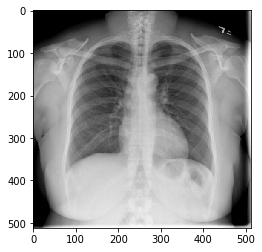

In [91]:
img1=Image.open(dirname+'/data/sample/CXR1009_IM-0010-1001'+'.png')
img2=Image.open(dirname+'/data/sample/CXR1009_IM-0010-2001'+'.png')

imshow(np.asarray(img1))
img1=img_preprocess(img1)
img2=img_preprocess(img2)
result=evaluation(img1,img2) 
actual=y_test[0]

print("Actual Report: ",actual)
print("Generated Report: ",result) 
print("BLEU SCORE IS: ",sentence_bleu(actual,result))

In [ ]:
img1=Image.open(dirname+'/data/sample/CXR1026_IM-0021-2002'+'.png')
img2=Image.open(dirname+'/data/sample/CXR1026_IM-0021-2002'+'.png')

imshow(np.asarray(img1))
img1=img_preprocess(img1)
img2=img_preprocess(img2)
result=evaluation(img1,img2) 
actual=y_test[4]
print("Actual Report: ",actual)
print("Generated Report: ",result) 
print("BLEU SCORE IS: ",sentence_bleu(actual,result))

In [60]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
from matplotlib.pyplot import imshow